# Project DNN

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

import scipy
import os

## 1. Introduction

The objective of this project is to study deep neural networks for the classification of handwritten numbers. We will compare the performances, in terms of rate of good classifications, of a pre-trained network (using Deep Belief Networks) and of a randomly initialized network, as a function of the number of training data, the number of layers of the network and finally the number the number of neurons per layer.

## 2. Dataset Exploration

### 2.1 MNIST

In [2]:
def load_mnist():
  """
  This function import the mnist dataset which consists of 70,000 images of size 28*28.
  train size: 60,000
  test size: 10,000

  Each image is represented as a row of size 784 (flattend).
  Note that we will threshold to get binary images, and we will one-hot encode the labels to obtain y as a matrix of size n_samples*n_classes
  Reference: http://yann.lecun.com/exdb/mnist/
  It returns the training images, testing images and their respect labels.
  """
  mnist = fetch_openml('mnist_784')
  
  #Trunk the data
  n_train = 60000
  n_test = 10000

  #Define training and testing sets
  indices = np.arange(len(mnist.data))

  train_idx = np.arange(0,n_train)
  test_idx = np.arange(n_train+1,n_train+n_test)

  X_train, y_train = mnist.data[train_idx], mnist.target[train_idx].astype(int)
  X_test, y_test = mnist.data[test_idx], mnist.target[test_idx].astype(int)

  #Binarization
  threshold = 100
  X_train = np.array(X_train >= threshold, dtype=np.int8)
  X_test = np.array(X_test >= threshold, dtype=np.int8)

  #One-hot encoding
  n_values = np.max(y_train) + 1 #vector of size 10 to represent digits from 0 through 9

  y_train_o = np.eye(n_values)[y_train]
  y_test_o = np.eye(n_values)[y_test]
  
  return X_train, X_test, y_train_o, y_test_o

In [3]:
#load MNIST dataset
X_train, X_test, y_train, y_test = load_mnist()

In [3]:
def plot_digit(x, y, dataset='mnist'):
  """
  x: 1D np.array -> one flattend digit
  y: one-hot encoded label
  dataset: type of dataset used. mnist or alphadigit
  """
  assert dataset in ['mnist', 'alphadigit']
  n = -1

  if dataset == 'mnist':
    n = 28
    label = np.argmax(y)
  else:
    n=20
    label = y
  
  plt.figure()
  if dataset == 'mnist' or y.isdigit():
    plt.title("digit {0}".format(label))
  else:
    plt.title("character {0}".format(label))
  plt.imshow(x.reshape(n,-1), cmap='gray')
  plt.axis('off')
  plt.show()

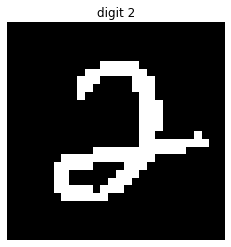

In [5]:
#visual example
sample_idx = 16
plot_digit(X_train[sample_idx], y_train[sample_idx])

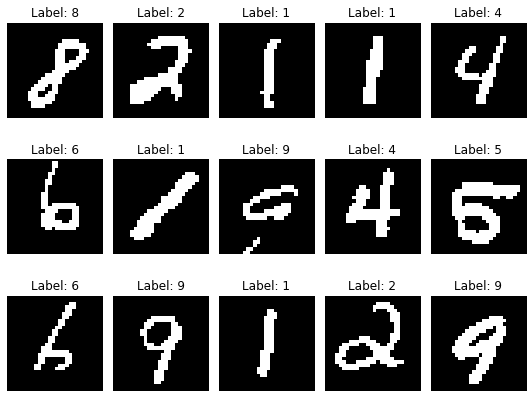

In [6]:
num_row = 3
num_col = 5
num = np.random.choice(np.arange(X_train.shape[0]), size=15)
images = X_train[num]
labels = np.argmax(y_train[num], axis=1)

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(len(num)):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

### 2.2 AlphaDigits

In [7]:
def get_char_ord(char='0'):
  """
  Get the order of character..
  '0-9' -> 0-9, 'A' -> 10, 'B' -> 11, ..., 'Z' -> 35
  """
  assert type(char) is str

  if char.isdigit():
    return int(char)
  else:
    return ord(char)-ord('A') + 10

In [8]:
def lire_alpha_digit(char='0'):
  """
  import the AlphaDigits dataset
  
  It consists of 20x16 Binary digits of "0" through "9" and capital "A" through "Z". 
  39 examples of each class.

  Only return the 39 examples corresponding the argument char.
  char: str "0" through "9" and capital "A" through "Z"


  reference: https://cs.nyu.edu/~roweis/data.html
  """

  file_name = "binaryalphadigs.mat"

  if not os.path.isfile(file_name): #check weither the file exist or not
    !wget https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat


  X = pd.DataFrame(scipy.io.loadmat(file_name)['dat'])   

  n_samples = len(X) * 39
  IMG = pd.DataFrame(np.zeros((n_samples, 20*16), dtype=np.int8))

  ligne = 0
  for i in range(X.shape[0]): 
      for j in range(X.shape[1]):
          IMG.iloc[ligne,:] = np.concatenate([X.iloc[i,j][k] for k in range(20)])
          ligne += 1

  indx_char = get_char_ord(char)
  
  return np.array(IMG)[39*indx_char:39*(indx_char+1)]

In [9]:
#load alpha digit
char = 'B'
X = lire_alpha_digit(char)
X.shape

--2021-04-03 11:08:31--  https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat
Resolving cs.nyu.edu (cs.nyu.edu)... 216.165.22.203
Connecting to cs.nyu.edu (cs.nyu.edu)|216.165.22.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532304 (520K) [text/plain]
Saving to: ‘binaryalphadigs.mat’

binaryalphadigs.mat 100%[===================>] 519.83K  --.-KB/s    in 0.1s    

2021-04-03 11:08:31 (4.91 MB/s) - ‘binaryalphadigs.mat’ saved [532304/532304]



(39, 320)

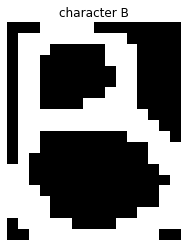

In [10]:
plot_digit(X[0], char, dataset='alphadigit')

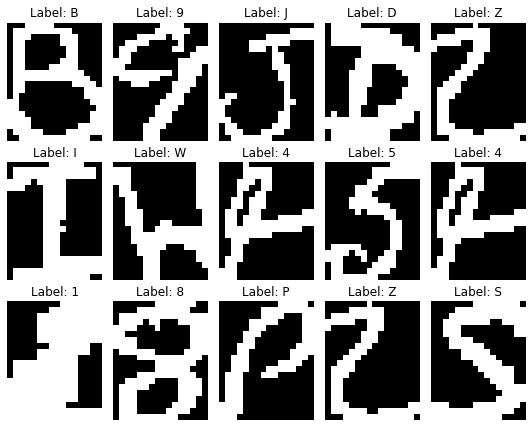

In [11]:
num_row = 3
num_col = 5
characters = ['{0}'.format(i) for i in range(10)] + list(map(chr, range(65, 91)))
indices = np.random.choice(np.arange(len(characters)), size=15)

images = []
labels = []

for char in indices:
  images.append(lire_alpha_digit(characters[char])[0])
  labels.append(characters[char])

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(len(num)):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].reshape(20,16), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3.1 `principal_RBM_alpha`

On veut apprendre les caractères de la base Binary AlphaDigits de votre choix via un RBM et de générer des caractères similaires à ceux appris.
La construction de ce programme nécessite les fonctions suivantes:

In [4]:
def lire_alpha_digit(char='0'):
  """
  import the AlphaDigits dataset
  
  It consists of 20x16 Binary digits of "0" through "9" and capital "A" through "Z". 
  39 examples of each class.

  Only return the 39 examples corresponding the argument char.
  char: str "0" through "9" and capital "A" through "Z"


  reference: https://cs.nyu.edu/~roweis/data.html
  """

  file_name = "binaryalphadigs.mat"

  if not os.path.isfile(file_name): #check weither the file exist or not
    !wget https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat


  X = pd.DataFrame(scipy.io.loadmat(file_name)['dat'])   

  n_samples = len(X) * 39
  IMG = pd.DataFrame(np.zeros((n_samples, 20*16), dtype=np.int8))

  ligne = 0
  for i in range(X.shape[0]): 
      for j in range(X.shape[1]):
          IMG.iloc[ligne,:] = np.concatenate([X.iloc[i,j][k] for k in range(20)])
          ligne += 1

  indx_char = get_char_ord(char)
  
  return np.array(IMG)[39*indx_char:39*(indx_char+1)]

In [5]:
class RBM:
  def __init__(self, p, q, sigma):
    """
    sigma: variance des poids
    """
    self.W = np.random.normal(0, sigma, size=(p,q))
    self.a = np.zeros(shape=(1, p))
    self.b = np.zeros(shape=(1, q))

In [6]:
def init_RBM(p, q, sigma=0.1):
  return RBM(p,q,sigma)

def sigmoid(x):
  return (1 / (1 + np.exp(-x)))

In [7]:
def entree_sortie_RBM(data, rbm):
  """
  data: matrice de taille mxp
  rbm: object du type RBM.
  """

  logits = data @ rbm.W + rbm.b

  return sigmoid(logits)


def sortie_entree_RBM(data, rbm):
  """
  data: matrice de taille mxq
  rbm: object du type RBM.
  """

  logits = data @ rbm.W.T + rbm.a

  return sigmoid(logits)

In [8]:
def train_RBM(rbm, epochs, lr, taille_batch, data):
  """
  faire le training du RBM en utilisant l'algorithm CD-1
  """

  n = data.shape[0]
  p, q = rbm.a.shape[1], rbm.b.shape[1]
  shuffled_index = np.arange(n)
  err_eqm = []

  for i in range(0, epochs):
    np.random.shuffle(shuffled_index)
    x = data[shuffled_index]
    for batch in range(0, n, taille_batch):
      data_batch = x[batch:min(batch+taille_batch, n), :]
      taille_batch = data_batch.shape[0]

      v0 = data_batch
      p_h_v0 = entree_sortie_RBM(v0, rbm)
      h_0 = 1* (np.random.rand(taille_batch, q) < p_h_v0)

      p_v_h0 = sortie_entree_RBM(h_0, rbm)
      v1 = 1* (np.random.rand(taille_batch, p) < p_v_h0)
      p_h_v1 = entree_sortie_RBM(v1, rbm)

      da = np.sum(v0 - v1, axis=0)
      db = np.sum(p_h_v0 - p_h_v1, axis=0)
      dW = v0.T @ p_h_v0 - v1.T @ p_h_v1

      rbm.W += lr * dW/taille_batch
      rbm.a += lr * da/taille_batch
      rbm.b += lr * db/taille_batch

      #fin du batch
    h = entree_sortie_RBM(data, rbm)
    x_recovered = sortie_entree_RBM(h, rbm)
    err = np.mean(np.sum((data - x_recovered)**2, axis=1))
    err_eqm.append(err)
  
  return rbm, err_eqm

In [9]:
def generer_image_RBM(rbm, nb_images, iter_gibbs, visualize = True):

  p, q = rbm.a.shape[1], rbm.b.shape[1]
  imgs = []
  for i in range(0, nb_images):
    v = 1* np.random.rand(1,p)<0.5
    for j in range(0, iter_gibbs):
      p_h = entree_sortie_RBM(v, rbm)
      h = 1* np.random.rand(1,q)<p_h 
      p_v = sortie_entree_RBM(h, rbm)
      v = 1* np.random.rand(1,p)<p_v 

    #fin generation
    imgs.append(1 * v.reshape(20, 16))

    if visualize:
      plt.figure()
      plt.imshow(imgs[-1], cmap='gray') # AlphaDigits
      plt.title("Generated image after {0} iterations".format(iter_gibbs))
      plt.show()

  return np.array(imgs)

Faire un example:

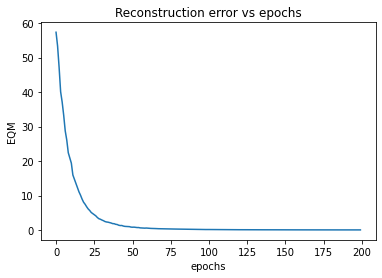

In [18]:
X_train = lire_alpha_digit('3')

p = X_train.shape[1]
q = 240

rbm = init_RBM(p, q)

n_epochs= 200
lr = 0.2
batch_size = 6

rbm, err_eqm = train_RBM(rbm, n_epochs, lr, batch_size, X_train)

plt.figure()
plt.plot(range(n_epochs), err_eqm)
plt.title('Reconstruction error vs epochs')
plt.xlabel('epochs')
plt.ylabel('EQM')
plt.show()

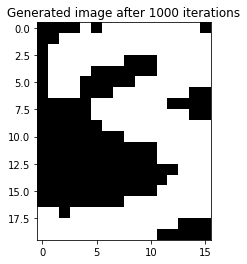

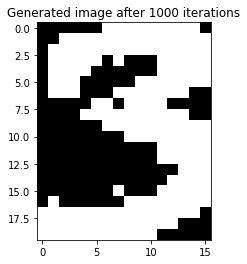

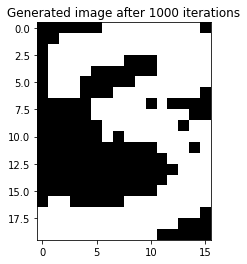

In [19]:
nb_images, nb_iterations = 3, 1000

x_generated_rbm = generer_image_RBM(rbm, nb_images, nb_iterations);

In [20]:
def plot_examples_alphadigits(X_train, x_generated, nb_iterations):
    """
    takes as input X_train (alphadigits stacked into rows) and x_generated a tensor of dimensiosn n_images x 20 x 16
    plots a comparaison between generated and training examples..
    """
    fig = plt.figure(figsize=(8, 8))
    n_generated = x_generated.shape[0]
    columns = min(n_generated, 4)
    rows = 2
    samples = np.random.choice(np.arange(X_train.shape[0]), size = columns, replace=False)

    plt.title("{0} examples generated with {1} Gibbs iterations".format(n_generated, nb_iterations))
    plt.axis('off')
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if i > columns:
          plt.imshow(X_train[i].reshape(20,16), cmap='gray')
          plt.title('ex {0}'.format(samples[i-columns-1]), y=-0.2)
        else:
          plt.imshow(x_generated[i-1], cmap='gray')
          plt.title('generated ex {0}'.format(i), y=-0.2)
        
        plt.axis('off')
    
    
    plt.show()

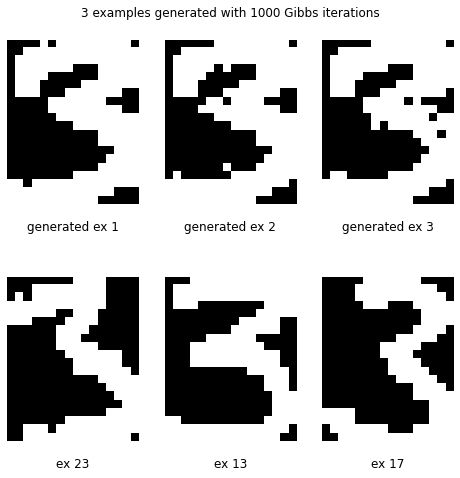

In [21]:
plot_examples_alphadigits(X_train, x_generated_rbm, nb_iterations)

### 3.1.1 RBM Analysis

In [22]:
def RBM_quant_analysis(char='3', q = 240, lr = 0.2, n_epochs = 200, batch_size = 6, visualize=True):
  """
  Plot the reconstractive error after training with the specified hyperparamters for a given character
  """

  X_train = lire_alpha_digit(char)
  p = X_train.shape[1]

  rbm = init_RBM(p, q)

  rbm, err_eqm = train_RBM(rbm, n_epochs, lr, batch_size, X_train)

  if visualize:
    plt.figure()
    plt.plot(range(n_epochs), err_eqm)
    plt.title('EQM: lr={0}, bs={1}, epochs={2}, q={3}, char={4}'.format(lr, batch_size, n_epochs, q, char))
    plt.xlabel('epochs')
    plt.ylabel('EQM')
    plt.show()

  return err_eqm

def RBM_qualt_analysis(rbm, X_train, nb_images = 3, nb_iterations = 1000):
  """
  Plot some examples after training with the specified hyperparamters for a given character
  """
  x_generated_rbm = generer_image_RBM(rbm, nb_images, nb_iterations, visualize=False)
  plot_examples_alphadigits(X_train, x_generated_rbm, nb_iterations)

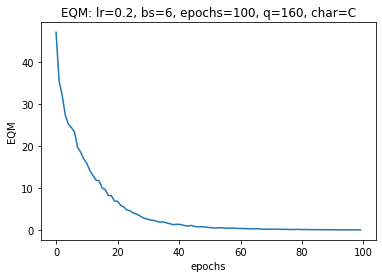

In [23]:
char = 'C'
q = 160
lr = 0.2
n_epochs= 100
batch_size = 6


RBM_quant_analysis(char, q, lr, n_epochs, batch_size);

In [24]:
char = 'C'
q = 160
lr = 0.2
n_epochs= 100
batch_size = 6
###
lrs = [1e-2, 1e-1, 1.5e-1, 2e-1, 2.5e-1, 3e-1, 5e-1]
batch_sizes = [1, 3, 6, 9, 18, 39]
n_epochss = [20, 40, 80, 100, 200]
qs = [260, 240, 220, 180, 160, 120, 80]
chars = ['A', 'S', 'X', '0', '8', '3']

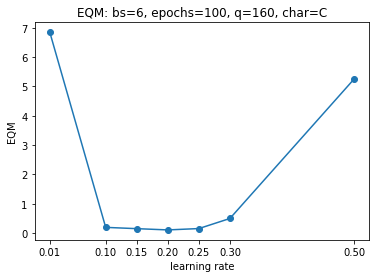

0.2

In [25]:
errs_lr = []

for lr in lrs:
  errs_lr.append(RBM_quant_analysis(char, q, lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(lrs, errs_lr, marker='o')
plt.title('EQM: bs={0}, epochs={1}, q={2}, char={3}'.format(batch_size, n_epochs, q, char))
plt.xlabel('learning rate')
plt.xticks(lrs)
plt.ylabel('EQM')
plt.show()

best_lr = lrs[np.argmin(errs_lr)]
best_lr

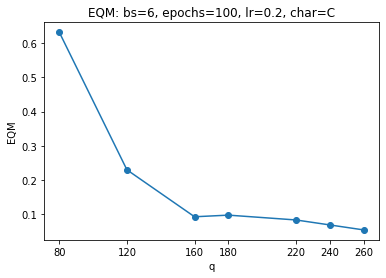

260

In [26]:
errs_q = []

for q in qs:
  errs_q.append(RBM_quant_analysis(char, q, best_lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(qs, errs_q, marker='o')
plt.title('EQM: bs={0}, epochs={1}, lr={2}, char={3}'.format(batch_size, n_epochs, best_lr, char))
plt.xlabel('q')
plt.xticks(qs)
plt.ylabel('EQM')
plt.show()

best_q = qs[np.argmin(errs_q)]
best_q

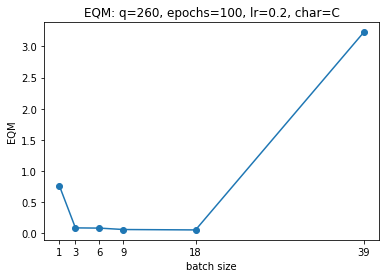

18

In [27]:
errs_bs = []

for batch_size in batch_sizes:
  errs_bs.append(RBM_quant_analysis(char, best_q, best_lr, n_epochs, batch_size, False)[-1])

plt.figure()
plt.plot(batch_sizes, errs_bs, marker='o')
plt.title('EQM: q={0}, epochs={1}, lr={2}, char={3}'.format(best_q, n_epochs, best_lr, char))
plt.xlabel('batch size')
plt.xticks(batch_sizes)
plt.ylabel('EQM')
plt.show()

best_bs = batch_sizes[np.argmin(errs_bs)]
best_bs

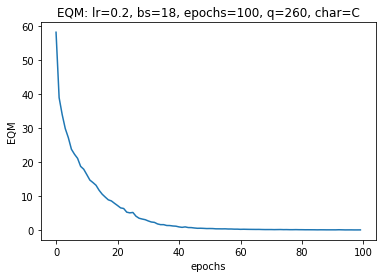

In [28]:
RBM_quant_analysis(char, best_q, best_lr, n_epochs, best_bs, True);

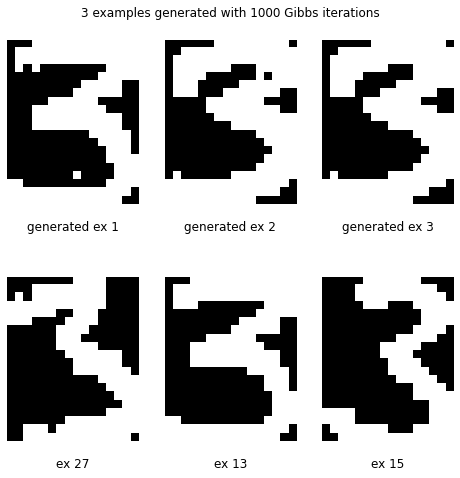

In [29]:
##qualitative analysis

char='3'
X_train = lire_alpha_digit(char)

rbm = init_RBM(p, best_q)
n_epochs= 100

rbm, err_eqm = train_RBM(rbm, n_epochs, best_lr, best_bs, X_train)

nb_iterations=1000
RBM_qualt_analysis(rbm, X_train, 3, nb_iterations)

## 3.2 `principal_DBN_alpha`



In [10]:
class DBN:
  def __init__(self, layers, hidden_units):
    """
    layers: minimum 1 layer -> RBM
    hidden_units: must be equal to layers + 1
    """

    assert(layers>=1)

    self.layers = [None] * layers
    self.hidden_units = hidden_units
    self.num_layers = layers

    for layer, layer_units in enumerate(hidden_units):
      self.layers[layer] = init_RBM(layer_units[0], layer_units[1])
    

In [11]:
def init_DNN(layers, hidden_units):
  return DBN(layers, hidden_units)

In [12]:
def pretrain_DNN(dbn, epochs, lr, taille_batch, data):

  err_layers = []
  x = data.copy()

  for i in range(dbn.num_layers):
    dbn.layers[i], err_eqm = train_RBM(dbn.layers[i], epochs, lr, taille_batch, x)
    err_layers.append(err_eqm)
    x = entree_sortie_RBM(x, dbn.layers[i])

  return dbn, err_layers
 

In [13]:
def generer_image_DBN(dbn, nb_images, iter_gibbs, visualize = True):

  p, q = dbn.layers[0].a.shape[1], dbn.layers[-1].b.shape[1]
  imgs = []

  for i in range(0, nb_images):
    v = 1* np.random.rand(1,dbn.layers[-1].W.shape[0])<0.5

    for j in range(0, iter_gibbs):
      p_h = entree_sortie_RBM(v, dbn.layers[-1])
      h = 1* np.random.rand(p_h.shape[0],p_h.shape[1])<p_h 
      p_v = sortie_entree_RBM(h, dbn.layers[-1])
      v = 1* np.random.rand(p_v.shape[0],p_v.shape[1])<p_v 

    for l in range(dbn.num_layers-2, -1, -1):
      proba = sortie_entree_RBM(v, dbn.layers[l])
      v = 1* np.random.rand(proba.shape[0], proba.shape[1])<proba


    #fin generation
    imgs.append(1 * v.reshape(20, 16))
    if visualize:
      plt.figure()
      plt.imshow(imgs[-1], cmap='gray') # AlphaDigits
      plt.title("Generated image after {0} iterations".format(iter_gibbs))
      plt.show()

  return np.array(imgs)

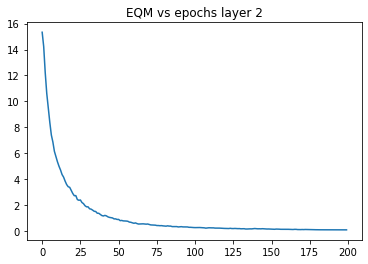

In [34]:
X_train = lire_alpha_digit('C')

p = X_train.shape[1]
q = 240
num_layers = 3 

dbn = init_DNN(num_layers, [(p, p//2), (p//2, p//4), (p//4,p//6)])

n_epochs= 200
lr = 0.2
batch_size = 6

dbn, err_eqm = pretrain_DNN(dbn, n_epochs, lr, batch_size, X_train)

plt.figure()
layer = 2
plt.plot(range(n_epochs), err_eqm[layer])
plt.title('EQM vs epochs layer {0}'.format(layer))
plt.show()

In [35]:
nb_generated, nb_iterations = 3, 1000

x_generated_dbn = generer_image_DBN(dbn, nb_generated, nb_iterations, False);

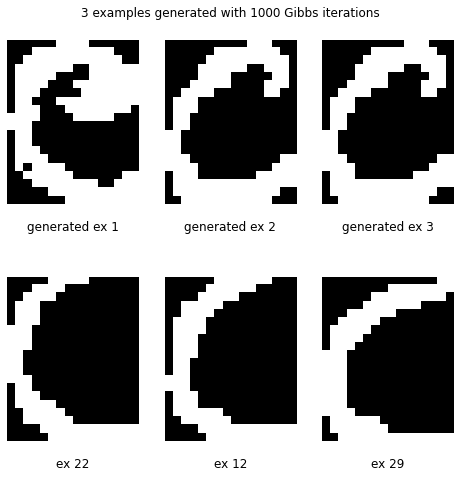

In [36]:
plot_examples_alphadigits(X_train, x_generated_dbn, nb_iterations)

### 3.2.1 DBN Analysis

In [37]:
def DBN_quant_analysis(char='3', num_layers = 3, neurons = None, lr = 0.2, n_epochs = 200, batch_size = 6, layer = 0, visualize=True):
  """
  Plot the reconstractive error after training with the specified hyperparamters for a given character
  """
  
  X_train = lire_alpha_digit(char)
  p = X_train.shape[1]
  if neurons is None:
    neurons = [(p, p//2), (p//2, p//4), (p//4,p//6)]

  assert num_layers == len(neurons)

  dbn = init_DNN(num_layers, neurons)

  dbn, err_eqm = pretrain_DNN(dbn, n_epochs, lr, batch_size, X_train)

  if visualize:
    plt.figure()
    plt.plot(range(n_epochs), err_eqm[layer])
    plt.title('EQM: lr={0}, bs={1}, epochs={2}, neruons={3}, char={4}, layer={5}'.format(lr, batch_size, n_epochs, "/".join([str(n[1]) for n in neurons]), char, layer))
    plt.xlabel('epochs')
    plt.ylabel('EQM')
    plt.show()

  return err_eqm

def DBN_qualt_analysis(dbn, X_train, nb_images = 3, nb_iterations = 1000):
  """
  Plot some examples after training with the specified hyperparamters for a given character
  """
  x_generated_dbn = generer_image_DBN(dbn, nb_images, nb_iterations, visualize=False)
  plot_examples_alphadigits(X_train, x_generated_dbn, nb_iterations)

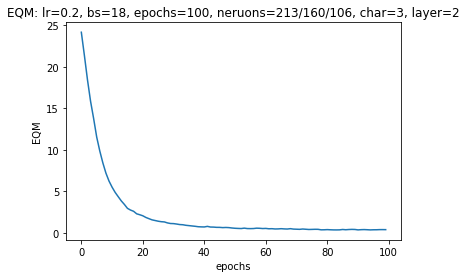

In [38]:
char = '3'

X_train = lire_alpha_digit(char)
p = X_train.shape[1]
num_layers = 3 
n_epochs= 100
neurons = [(p, 2*p//3), (2*p//3, p//2), (p//2,p//3)]

DBN_quant_analysis(char, num_layers, neurons, best_lr, n_epochs, best_bs, layer=2);

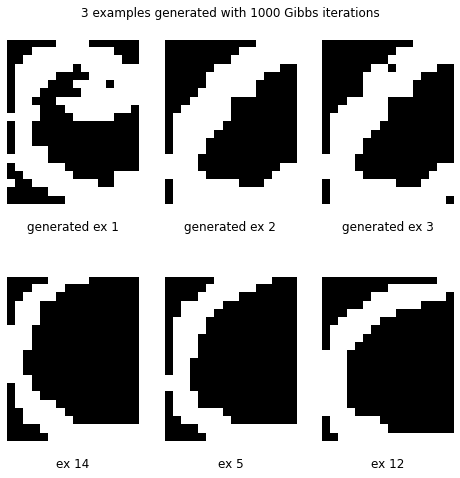

In [39]:
char = 'C'
X_train = lire_alpha_digit(char)
p = X_train.shape[1]
num_layers = 3 
neurons = [(p, 2*p//3), (2*p//3, p//2), (p//2,p//3)]

dbn = init_DNN(num_layers, neurons)
dbn, err_eqm = pretrain_DNN(dbn, n_epochs, best_lr, best_bs, X_train)

nb_images, nb_iterations = 3, 1000
DBN_qualt_analysis(dbn, X_train, nb_images, nb_iterations)

## 3.3 `principal_DNN_MNIST`

In [14]:
def calcul_softmax(rbm, data):
    A = np.dot(data, rbm.W) + rbm.b
    e = np.exp(A - np.max(A, axis=1).reshape((-1, 1)))
    return  e / e.sum(axis=1).reshape((-1,1))

In [15]:
def entree_sortie_reseau(dnn, X):
    sorties_couches = []
    sorties_couches.append(entree_sortie_RBM(X, dnn.layers[0]))
    for i in range(1, dnn.num_layers-1):
        sorties_couches.append(entree_sortie_RBM(sorties_couches[-1], dnn.layers[i]))
    sorties_couches.append(calcul_softmax(dnn.layers[-1], sorties_couches[-1]))
    return sorties_couches

In [16]:
def copy_dnn(dnn):
    new_dnn = init_DNN(dnn.num_layers, [dnn.layers[i].W.shape for i in range(dnn.num_layers)])
    for i in range(dnn.num_layers):
        new_dnn.layers[i].a = dnn.layers[i].a.copy()
        new_dnn.layers[i].b = dnn.layers[i].b.copy()
        new_dnn.layers[i].W = dnn.layers[i].W.copy()
    return new_dnn


In [17]:
def retropropagation(dnn, X_train, Y_train, nb_iter, lr, batch_size, pre_trained, visualize = True):
    if type(X_train) == 'pandas.core.frame.DataFrame':
            X_train = X_train.values
    entrop_crois = []
    for ploud in range(nb_iter):
        indices = np.arange(0,X_train.shape[0],1)
        np.random.shuffle(indices)
        for j in range(0, X_train.shape[0], batch_size):
            new_dnn = copy_dnn(dnn)
            batch_ind = indices[j:min(j+batch_size, X_train.shape[0])]
            data = X_train[batch_ind,:]
            sorties_couches = entree_sortie_reseau(dnn, data)
            
            ## début dernière couche
            matrice_c = sorties_couches[-1] - Y_train[batch_ind]
            der_w = np.dot(sorties_couches[dnn.num_layers-2].transpose(), matrice_c)/data.shape[0]
            der_b = matrice_c.sum(0)/data.shape[0]
            new_dnn.layers[-1].W -= lr*der_w #/batch
            new_dnn.layers[-1].b -= lr*der_b
            ## fin dernière couche
            
            for couche in range(dnn.num_layers-2, -1, -1):
                
                if couche == 0:
                    inpute = data
                else:
                    inpute = sorties_couches[couche-1]
                
                h_mult = sorties_couches[couche]*(1-sorties_couches[couche])
                matrice_c = np.dot(matrice_c, dnn.layers[couche+1].W.transpose())*h_mult                
                der_w = np.dot(inpute.transpose(), matrice_c)/data.shape[0]
                der_b = matrice_c.sum(0)/data.shape[0]
                new_dnn.layers[couche].W -= lr*der_w
                new_dnn.layers[couche].b -= lr*der_b
            
            dnn = copy_dnn(new_dnn)
        sorties_couches = entree_sortie_reseau(dnn, X_train)
        classif = -np.log10(sorties_couches[-1])[Y_train==1]
        erreur = classif.sum()
        entrop_crois.append(erreur)

    if visualize:
      f = plt.figure(figsize=(10, 7))
      plt.plot(range(nb_iter), entrop_crois)
      plt.legend(['Entropie croisée'])
      plt.title("Évolution de l'entropie croisée au cours des iterations")
      plt.xlabel("nombre d'itérations")
      plt.ylabel('entropie croisée')
      f.savefig('retropropagation_{}.png'.format(pre_trained))
      return dnn
    
    else:
      return dnn, entrop_crois[-1]

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def accuracy_score(y_test, y_pred):
    result = (y_test != y_pred)
    return "Accuracy : {}%".format(round((1 - (result.sum()//2)/y_test.shape[0])*100*100)/100)


def matrice_de_confusion(y_test, y_pred, erreur, pre_trained):
    y_t = []
    y_p = []
    for i in range(y_test.shape[0]):
        for j in range(y_test.shape[1]):
            if y_test[i,j] == 1:
                y_t.append(j)
            if y_pred[i,j] == 1:
                y_p.append(j)
    df_cm = pd.DataFrame(confusion_matrix(y_t, y_p), index = range(10), columns = range(10))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.title("MATRICE DE CONFUSION {} \n {}\n Entropie croisée : {}".format(pre_trained, accuracy_score(y_test, y_pred), round(erreur*100)/100))
    plt.savefig('confusion_mat_{}.png'.format(pre_trained))



def test_DNN(dnn, X_test, y_test, pre_trained, visualize = True):
    y_pred = entree_sortie_reseau(dnn, X_test)[-1]
    classif = -np.log10(y_pred)[y_test==1]
    erreur = classif.sum()
    print("entropie croisée :", erreur)
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_pred[i,j] == max(y_pred[i,:]):
                y_pred[i,j] = 1
            else:
                y_pred[i,j] = 0
    print(accuracy_score(y_test, y_pred))
    if visualize:
      matrice_de_confusion(y_test, y_pred, erreur, pre_trained)

    return float(accuracy_score(y_test, y_pred).split(':')[-1].split('%')[0])/100, erreur

## 5. MNIST Study

In [18]:
X, X_test, y, y_test = load_mnist()

### 5.1 Etude à réaliser (MNIST)

In [85]:
p = X.shape[1]
q = 10

neurons = [(p, 500), (500, 300), (300, 200), (200, 100), (100, q)]
num_layers = len(neurons)

n_epochs= 10
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [86]:
dnn = init_DNN(num_layers, neurons)

In [87]:
dnn, _ = pretrain_DNN(dnn, n_epochs, lr, batch_size, X_train)

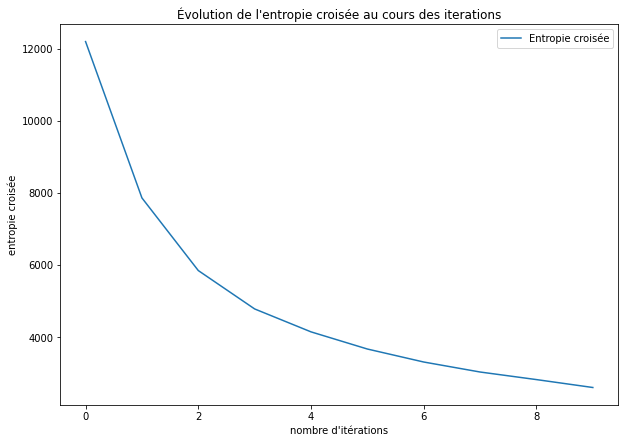

In [88]:
dnn = retropropagation(dnn, X_train, y_train, n_epochs, lr, batch_size, "normal")

entropie croisée : 606.9346518163909
Accuracy : 96.15%


(0.9615, 606.9346518163909)

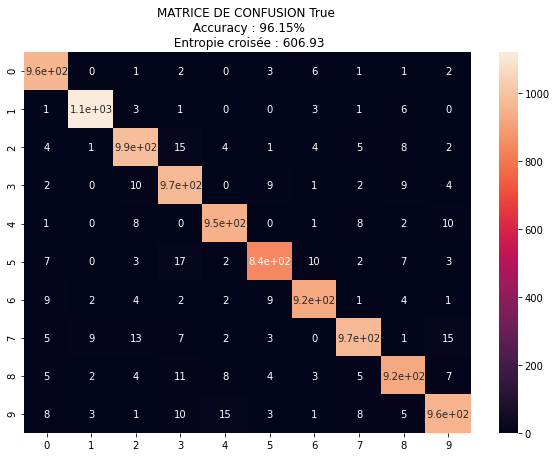

In [273]:
test_DNN(dnn, X_test, y_test, True)

### 5.2 Analyse

In [152]:
X, X_test, y, y_test = load_mnist()

#### 5.2.1 En fonction du **nombre de couches**

In [182]:
##fixed parameteres

p = X.shape[1]
q = 10

hidden_units = 200
n_epochs_rbm = 30
n_epochs_retro = 20
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [183]:
##variable parameteres

test_layers = 5

first_layer = [(p, hidden_units)]
last_layer = [(hidden_units, q)]
neurons_v = [[(p, hidden_units), (hidden_units, q)]]

for i in range(1, test_layers):
  neurons_v += [first_layer + [(hidden_units,hidden_units)]*i + last_layer]

In [184]:
neurons_v

[[(784, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 200), (200, 10)],
 [(784, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 10)]]

In [185]:
##track of error the tests
acc_pre, crossentropy_pre = [], []
acc_norm, crossentropy_norm = [], []

In [186]:
for neurons in neurons_v:
  num_layers = len(neurons)

  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} hidden layers".format(num_layers-1))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc_pre.append(test_scores[0])
  crossentropy_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} hidden layers".format(num_layers-1))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc_norm.append(test_scores[0])
  crossentropy_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 2 layers
entropie croisée : 1084.228052431244
Accuracy : 92.98%


Normal with 2 layers
entropie croisée : 851.3386504580333
Accuracy : 94.36%
-----------------
Pre-trained with 3 layers
entropie croisée : 913.5908525581499
Accuracy : 93.82%


Normal with 3 layers
entropie croisée : 876.4910520060004
Accuracy : 93.88%
-----------------
Pre-trained with 4 layers
entropie croisée : 689.050641195827
Accuracy : 95.38%


Normal with 4 layers
entropie croisée : 839.7650329068808
Accuracy : 94.16%
-----------------
Pre-trained with 5 layers
entropie croisée : 591.1004183387635
Accuracy : 96.07%


Normal with 5 layers
entropie croisée : 838.6471047829591
Accuracy : 94.44%
-----------------
Pre-trained with 6 layers
entropie croisée : 570.2973695589367
Accuracy : 96.19%


Normal with 6 layers
entropie croisée : 1139.5256645446411
Accuracy : 92.63%
-----------------


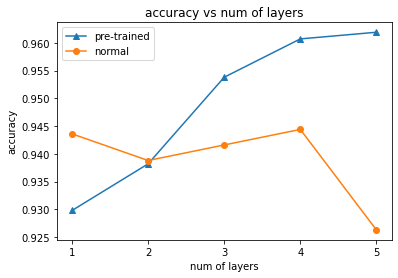

In [189]:
##visualization
variables = np.arange(1, test_layers+1)

plt.figure()
plt.plot(variables, acc_pre, marker='^', label='pre-trained')
plt.plot(variables, acc_norm, marker='o', label='normal')
plt.xticks(variables)
plt.xlabel('num of layers')
plt.ylabel('accuracy')
plt.title('accuracy vs num of layers')
plt.legend()
plt.savefig("acc_vs_numlayers.png")
plt.show()

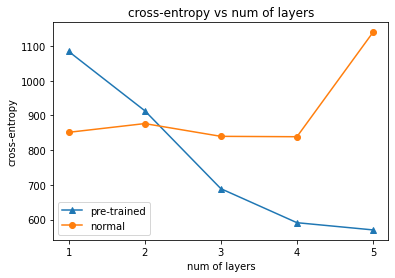

In [190]:
##visualization
variables = np.arange(1, test_layers+1)

plt.figure()
plt.plot(variables, crossentropy_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy_norm, marker='o', label='normal')
plt.xticks(variables)
plt.xlabel('num of layers')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs num of layers')
plt.legend()
plt.savefig("crosse_vs_numlayers.png")
plt.show()

#### 5.2.2 En fonction du **nombre de nombre de neurones par couches**

In [233]:
##fixed parameteres

p = X.shape[1]
q = 10

num_layers = 3 # 2 hidden layers
n_epochs_rbm = 30
n_epochs_retro = 20
lr = 0.15
batch_size = 100

training_samples = X.shape[0]//2
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [249]:
##variable parameteres

hidden_units_v = [100, 200, 300, 500, 1000]
neurons_v = []
for hidden_units in hidden_units_v:
  neurons_v.append([(p, hidden_units), (hidden_units,hidden_units), (hidden_units, q)])

In [250]:
neurons_v

[[(784, 100), (100, 100), (100, 10)],
 [(784, 200), (200, 200), (200, 10)],
 [(784, 300), (300, 300), (300, 10)],
 [(784, 500), (500, 500), (500, 10)],
 [(784, 1000), (1000, 1000), (1000, 10)],
 [(784, 1500), (1500, 1500), (1500, 10)]]

In [251]:
##track of error the tests
acc2_pre, crossentropy2_pre = [], []
acc2_norm, crossentropy2_norm = [], []

In [252]:
for idx, neurons in enumerate(neurons_v):
  
  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} hidden units".format(hidden_units_v[idx]))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc2_pre.append(test_scores[0])
  crossentropy2_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} hidden units".format(hidden_units_v[idx]))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc2_norm.append(test_scores[0])
  crossentropy2_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 100 hidden units
entropie croisée : 977.4703372054357
Accuracy : 93.64%


Normal with 100 hidden units
entropie croisée : 832.0573948724991
Accuracy : 94.14%
-----------------
Pre-trained with 200 hidden units
entropie croisée : 868.861683617449
Accuracy : 94.33%


Normal with 200 hidden units
entropie croisée : 831.7791334960748
Accuracy : 94.03%
-----------------
Pre-trained with 300 hidden units
entropie croisée : 785.5423300296359
Accuracy : 94.74%


Normal with 300 hidden units
entropie croisée : 867.2596681224371
Accuracy : 94.13%
-----------------
Pre-trained with 500 hidden units
entropie croisée : 780.9698557157691
Accuracy : 94.59%


Normal with 500 hidden units
entropie croisée : 883.5334598742642
Accuracy : 93.82%
-----------------
Pre-trained with 1000 hidden units
entropie croisée : 902.625154811976
Accuracy : 94.26%


Normal with 1000 hidden units
entropie croisée : 747.6069645719789
Accuracy : 94.9%
-----------------


KeyboardInterrupt: ignored

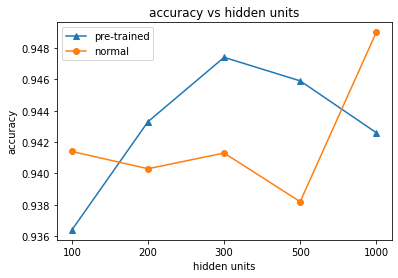

In [253]:
##visualization
variables = np.arange(1, len(hidden_units_v)+1)

plt.figure()
plt.plot(variables, acc2_pre, marker='^', label='pre-trained')
plt.plot(variables, acc2_norm, marker='o', label='normal')
plt.xticks(variables, hidden_units_v)
plt.xlabel('hidden units')
plt.ylabel('accuracy')
plt.title('accuracy vs hidden units')
plt.legend()
plt.savefig("acc_vs_hiddenunits.png")
plt.show()

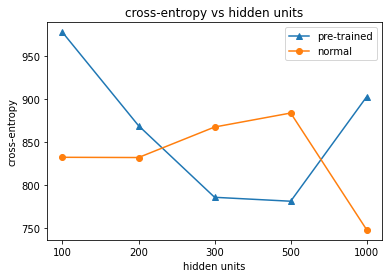

In [254]:
##visualization
variables = np.arange(1, len(hidden_units_v)+1)

plt.figure()
plt.plot(variables, crossentropy2_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy2_norm, marker='o', label='normal')
plt.xticks(variables, hidden_units_v)
plt.xlabel('hidden units')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs hidden units')
plt.legend()
plt.savefig("crosse_vs_hiddenunits.png")
plt.show()

#### 5.2.3 En fonction du **nombre de données train**

In [217]:
##fixed parameteres
p = X.shape[1]
q = 10

hidden_units = 200
num_layers = 3 # 2 hidden layers
neurons = [(p, hidden_units), (hidden_units, hidden_units), (hidden_units, q)]
n_epochs_rbm = 20
n_epochs_retro = 20
lr = 0.15
batch_size = 100

In [218]:
##variable parameteres
training_samples_v = [1000, 3000, 7000, 10000, 30000, 60000]

In [219]:
##track of error the tests
acc3_pre, crossentropy3_pre = [], []
acc3_norm, crossentropy3_norm = [], []

In [220]:
for training_samples in training_samples_v:
  X_train, y_train = X[:training_samples, :], y[:training_samples]

  #initialize identical networks
  dnn_pre = init_DNN(num_layers, neurons)
  dnn_norm = copy_dnn(dnn_pre)

  #pre-entrain one and fine-tune
  dnn_pre, _ = pretrain_DNN(dnn_pre, n_epochs_rbm, lr, batch_size, X_train)
  dnn_pre, _ = retropropagation(dnn_pre, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained", False)
  print("Pre-trained with {0} training samples".format(training_samples))
  test_scores = test_DNN(dnn_pre, X_test, y_test, "", False)
  acc3_pre.append(test_scores[0])
  crossentropy3_pre.append(test_scores[1])

  print("\n")

  #use the initial network without pre-entraining
  dnn_norm, _ = retropropagation(dnn_norm, X_train, y_train, n_epochs_retro, lr, batch_size, "normal", False)
  print("Normal with {0} training samples".format(training_samples))
  test_scores = test_DNN(dnn_norm, X_test, y_test, "", False)
  acc3_norm.append(test_scores[0])
  crossentropy3_norm.append(test_scores[1])

  print("-----------------")

Pre-trained with 1000 training samples
entropie croisée : 3828.864167939101
Accuracy : 74.25%


Normal with 1000 training samples
entropie croisée : 4469.683993730946
Accuracy : 73.23%
-----------------
Pre-trained with 3000 training samples
entropie croisée : 1764.9238261491519
Accuracy : 88.32%


Normal with 3000 training samples
entropie croisée : 2006.0468758441075
Accuracy : 86.74%
-----------------
Pre-trained with 7000 training samples
entropie croisée : 1429.549071114219
Accuracy : 90.45%


Normal with 7000 training samples
entropie croisée : 1474.5359255355584
Accuracy : 90.14%
-----------------
Pre-trained with 10000 training samples
entropie croisée : 1247.4522818713363
Accuracy : 91.55%


Normal with 10000 training samples
entropie croisée : 1325.9429390037237
Accuracy : 91.0%
-----------------
Pre-trained with 30000 training samples
entropie croisée : 847.4096155541234
Accuracy : 94.12%


Normal with 30000 training samples
entropie croisée : 828.6852642148916
Accuracy : 94

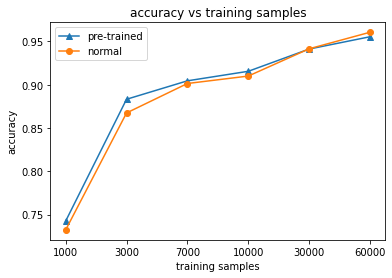

In [231]:
##visualization
variables = np.arange(1, len(training_samples_v)+1)

plt.figure()
plt.plot(variables, acc3_pre, marker='^', label='pre-trained')
plt.plot(variables, acc3_norm, marker='o', label='normal')
plt.xticks(variables, training_samples_v)
plt.xlabel('training samples')
plt.ylabel('accuracy')
plt.title('accuracy vs training samples')
plt.legend()
plt.savefig("acc_vs_trsamples.png")
plt.show()

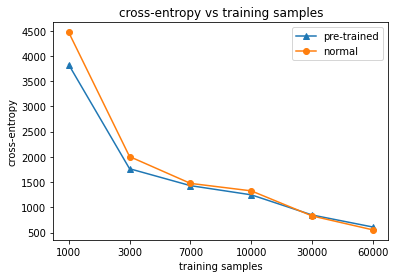

In [232]:
##visualization
variables = np.arange(1, len(training_samples_v)+1)

plt.figure()
plt.plot(variables, crossentropy3_pre, marker='^', label='pre-trained')
plt.plot(variables, crossentropy3_norm, marker='o', label='normal')
plt.xticks(variables, training_samples_v)
plt.xlabel('training samples')
plt.ylabel('cross-entropy')
plt.title('cross-entropy vs training samples')
plt.legend()
plt.savefig("crosse_vs_trsamples.png")
plt.show()

### 5.3 Classification

In [20]:
X, X_test, y, y_test = load_mnist()

In [21]:
p = X.shape[1]
q = 10

neurons = [(p, 300), (300, 300), (300, 200), (200,q)]
num_layers = len(neurons)
n_epochs_rbm = 60
n_epochs_retro = 100
lr = 0.2
batch_size = 100

training_samples = X.shape[0]
X_train, y_train = X[:training_samples, :], y[:training_samples]

In [22]:
dnn = init_DNN(num_layers, neurons)
dnn_normal = copy_dnn(dnn)

In [23]:
dnn, _ = pretrain_DNN(dnn, n_epochs_rbm, lr, batch_size, X_train)

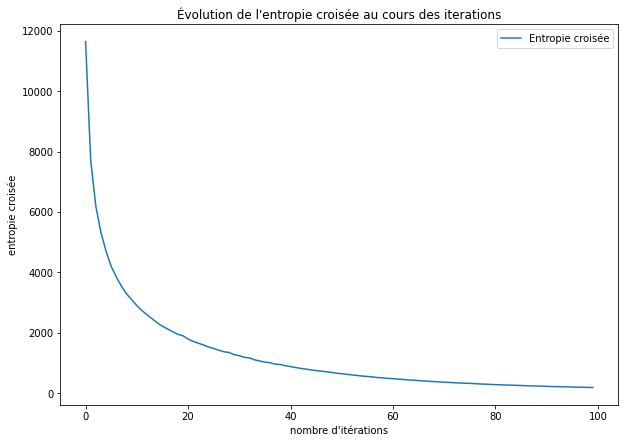

In [24]:
dnn = retropropagation(dnn, X_train, y_train, n_epochs_retro, lr, batch_size, "pre-trained")

entropie croisée : 327.54245794458853
Accuracy : 97.7%


(0.977, 327.54245794458853)

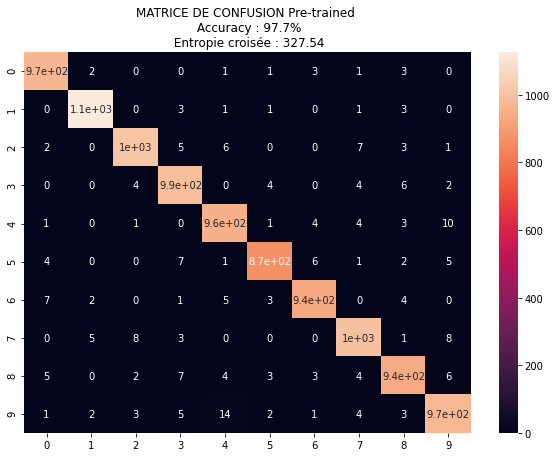

In [25]:
test_DNN(dnn, X_test, y_test, "Pre-trained")

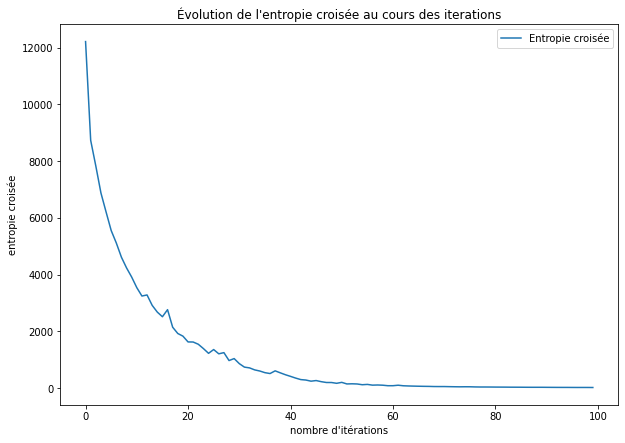

In [26]:
dnn_normal = retropropagation(dnn_normal, X_train, y_train, n_epochs_retro, lr, batch_size, "normal")

entropie croisée : 436.4069323921005
Accuracy : 97.61%


(0.9761, 436.4069323921005)

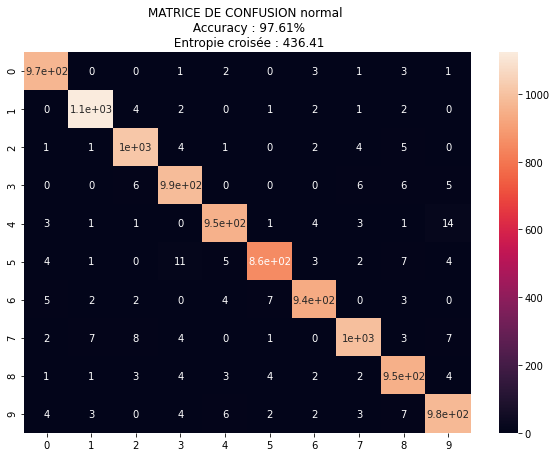

In [27]:
test_DNN(dnn_normal, X_test, y_test, "normal")